In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tabulate import tabulate

In [2]:
df = pd.read_csv('data.csv')
bm = pd.read_csv('complete_instance_list_data.csv', header = None)
bm.rename(columns = {0: 'instance', 1: '#V', 2: '#E', 6:'opt'}, inplace = True)

Summary of created dataframes. throughout the notebook:
- **bm**: Dataframe of the csv file containing optimum values of the library
     - **bmk**: Subdataframe of bm, of the instances where the optimum value is known
         - **r_bmk**: Dataframe containing the instances for which the optimum value is known, where the entries are the (heuristic_solution)/(optimum_solution)
     - **bmu**: Subdataframe of bm, of the isntances where the optimum value is not known
         - **r_bmu**: Dataframe containing the instances for which the optimum value is not known, with values normalised in the following manner: For each instance the solution value is divided by the maximum achieved cut value
- **df**: Contains all the data generated by running the solvers. The rows are indexed by the instance name, the columns contain the returned heuristic max cut value and the number of iterations denoted by MxxNyy.val and MxxNyy.iter respectively
 - **val**: Subdataframe of df containing only the heuristic values
 - **itr**: Subdataframe of df containing only the number of iterations


In [3]:
dict(list(enumerate(df.iloc[:,0])))
df.rename(index = dict(list(enumerate(df.iloc[:,0]))), inplace =True)
#df = df.transpose()

#check if the new index identical to instance (.mc) col of df
assert df['instance (.mc)'].eq(df.index).all()

df.drop(columns='instance (.mc)', inplace = True)
val = df.filter(regex = 'val$', axis=1)
itr = df.filter(regex = 'iter$', axis =1)

### The instance list where the solvers are run is not the same as in the 'complete_instance_list_data.csv'! Handle with care!
In order to handle this, during the course of the analysis we index by the instance name. This allows 

In [4]:
pd.read_csv('data.csv')['instance (.mc)'].eq(bm['instance']).all()

False

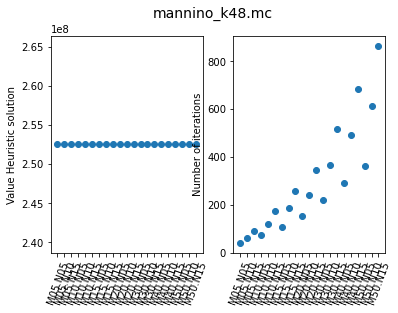

In [5]:
def plot_style(instance,val,itr):

    fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols=2)
    ax1.scatter([instance[:-4] for instance in val.columns], val.loc[instance])
    ax1.set_ylabel('Value Heuristic solution')
    plt.setp(ax1.get_xticklabels(), rotation=70)
#     ax2.scatter([x for x in range(len(df.columns)) if x%2 ==1], itr.loc[instance])
    ax2.scatter([instance[:-5] for instance in itr.columns], itr.loc[instance])
    ax2.set_ylabel('Number of iterations')
    fig.suptitle(instance, fontsize=14)
    plt.xticks(rotation = 70)
#     fig.tight_layout()
    
    plt.show()

plot_style('mannino_k48.mc',val,itr)

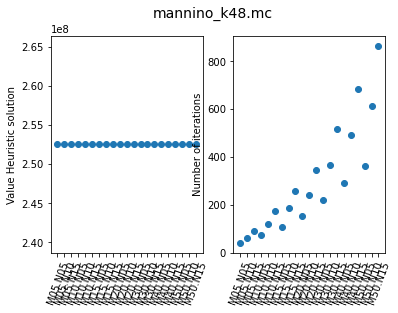

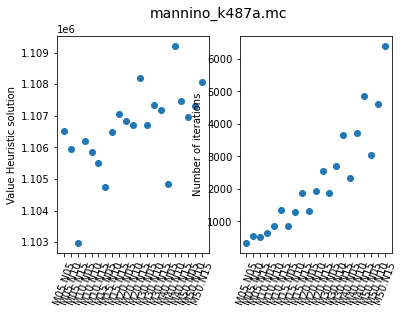

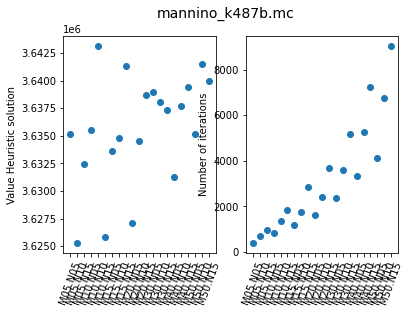

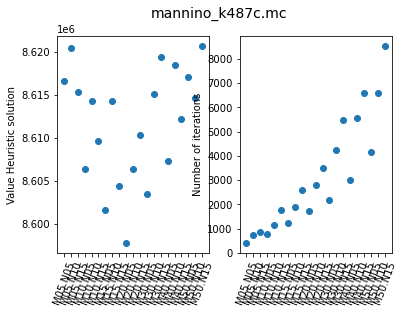

In [6]:
M = val.filter(regex = 'mannino', axis =0)
M = itr.filter(regex = 'mannino', axis =0)

for instance in M.index:
    plot_style(instance,val,itr)

# Analysis of instances where optimum value is known
The next step is to filter out the instances where ??all?? solvers reach optimum value.  
We first restrict ourselves to the the subset of instances where the optimum value is known

In [7]:
#remove instances where opt value is not known
bmk = bm[bm['opt'].notna()]

np.where(bm.applymap(lambda x: x == ''))

#rename the index to the instance name
bmk.reset_index(inplace=True)
bmk = bmk.rename(index = dict(list(enumerate([ inst + '.mc' for inst in bmk['instance']]))), inplace =False)

In [8]:
#bmk = bm[bm['opt'].notna()]
#bmk.rename(index = dict(list(enumerate(bmk.iloc[:,0]))), inplace =True)
#bmk.set_index([instance +'.mc' for instance in bmk['instance']], inplace = True) 

In [9]:
#list of instances with known optimal values
kopt_list = val.index.intersection(bmk.index)
r_bmk = val.loc[kopt_list]
for instance in kopt_list:
    r_bmk.loc[instance] = val.loc[instance] / abs(bmk.loc[instance,'opt'])

### <span style="color:red"> There is one instance where the heuristic solution appears to be greater than the optimal solution !!?? </span>

In [10]:
r_bmk.loc[(r_bmk>1).any(axis=1)]

,M05.N05.val,M05.N10.val,M05.N15.val,M10.N05.val,M10.N10.val,M10.N15.val,M15.N05.val,M15.N10.val,M15.N15.val,M20.N05.val,...,M20.N15.val,M30.N05.val,M30.N10.val,M30.N15.val,M40.N05.val,M40.N10.val,M40.N15.val,M50.N05.val,M50.N10.val,M50.N15.val
bqp500-2.mc,0.997481,0.998113,0.994697,0.997925,0.995562,0.999758,0.997723,0.999984,0.9983,0.999399,...,0.998503,0.999501,1.000218,0.999782,0.99961,1.000047,0.999197,0.998916,0.999633,1.000359


In [11]:
bmk.loc['bqp500-2.mc']

index             32
instance    bqp500-2
#V               501
#E             12778
3                500
4              12278
5                 39
opt          -128223
Name: bqp500-2.mc, dtype: object

Next we can ask the question for which instances, every solver obtains the optimum value:

In [12]:
r_bmk.loc[(r_bmk==1).all(axis=1)].index

Index(['be100.1.mc', 'be100.10.mc', 'be100.2.mc', 'be100.4.mc', 'be100.5.mc',
       'be100.6.mc', 'be100.7.mc', 'be120.3.10.mc', 'be120.3.2.mc',
       'be120.3.4.mc',
       ...
       'w01_100.4.mc', 'w01_100.5.mc', 'w01_100.6.mc', 'w01_100.7.mc',
       'w01_100.8.mc', 'w05_100.2.mc', 'w05_100.3.mc', 'w09_100.3.mc',
       'w09_100.5.mc', 'w09_100.8.mc'],
      dtype='object', length=146)

Out of the 347 instances with known optimal values only for 43 instances none of the 21 solvers obtain the optimum value

In [13]:
not_opt_solved = r_bmk.loc[(r_bmk<1).all(axis=1)]

In [14]:
#r_bmk.loc[(r_bmk==1) & (r_bmk<1)).any(axis=1)]

In [15]:
print(r_bmk.shape)
for instance in r_bmk.iloc[344]:
    print(instance)

(347, 21)
0.9937833037300178
0.9986678507992895
1.0
1.0
1.0
0.9986678507992895
0.9986678507992895
1.0
1.0
0.9986678507992895
0.9986678507992895
1.0
1.0
0.9986678507992895
1.0
0.9986678507992895
0.9986678507992895
1.0
0.9986678507992895
0.9986678507992895
1.0


#### The next table gives a summary of the perfomance of the solvers on the instances, which none of the solvers solved optimally.
- summary: summarized performance of the 21 solvers on the not optimally solved instances

In [16]:
summary = not_opt_solved.T.describe().T
print(tabulate(summary[['mean','min','max']], headers='keys', tablefmt='psql'))

+----------------------+----------+----------+----------+
|                      |     mean |      min |      max |
|----------------------+----------+----------+----------|
| bqp500-1.mc          | 0.992631 | 0.981704 | 0.997298 |
| bqp500-4.mc          | 0.997591 | 0.995004 | 0.999769 |
| bqp500-6.mc          | 0.994431 | 0.987904 | 0.998259 |
| bqp500-7.mc          | 0.995571 | 0.988683 | 0.999681 |
| bqp500-8.mc          | 0.996229 | 0.991008 | 0.999531 |
| bqp500-9.mc          | 0.995215 | 0.98947  | 0.999197 |
| gka10b.mc            | 0.46073  | 0        | 0.863636 |
| gka1f.mc             | 0.996497 | 0.992401 | 0.999706 |
| gka2f.mc             | 0.996625 | 0.994439 | 0.999541 |
| gka3f.mc             | 0.995839 | 0.990473 | 0.998913 |
| gka4f.mc             | 0.997104 | 0.993836 | 0.999734 |
| gka5f.mc             | 0.995748 | 0.980484 | 0.999974 |
| gka9b.mc             | 0.692735 | 0.277372 | 0.875912 |
| ising2.5-150_5555.mc | 0.996042 | 0.992569 | 0.998335 |
| ising2.5-150

In [17]:
summary['max'].idxmin()

'gka10b.mc'

Next we plot the 10 instances with the lowest overall ratio

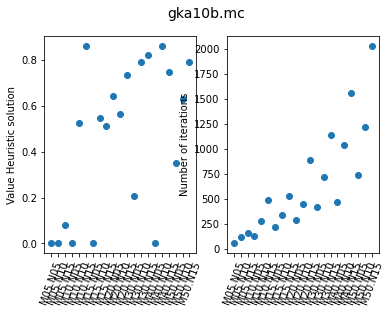

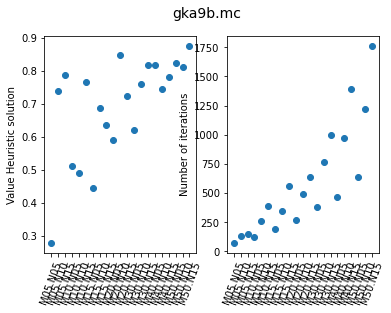

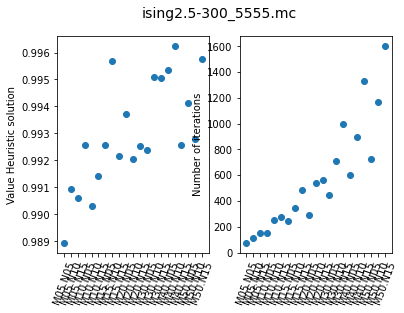

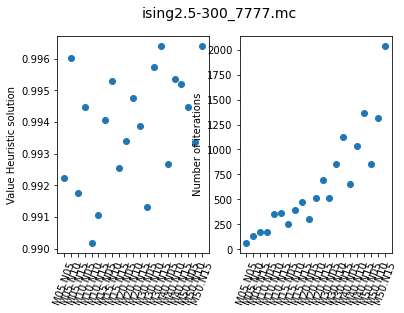

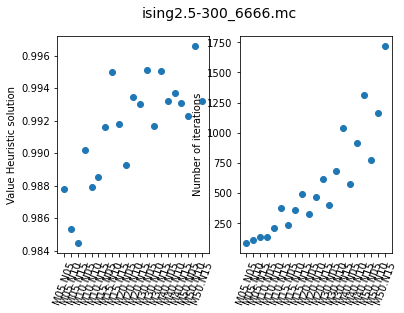

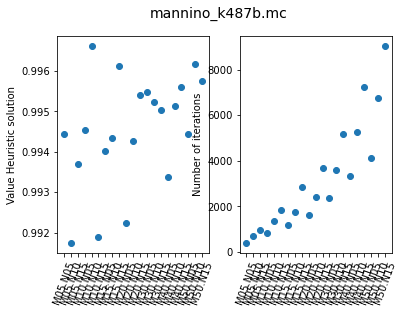

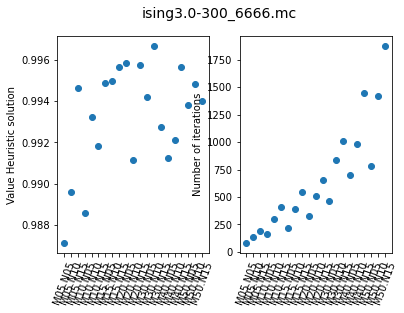

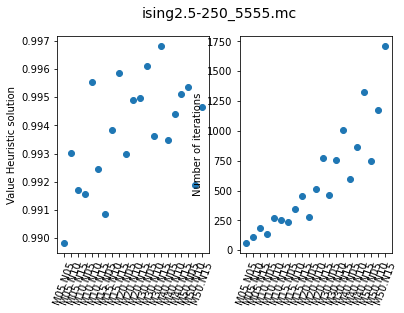

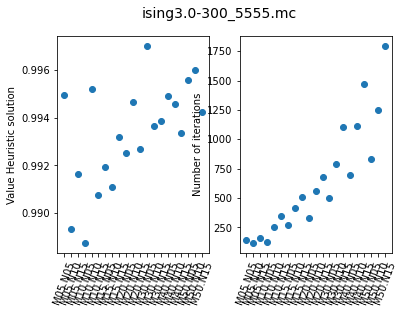

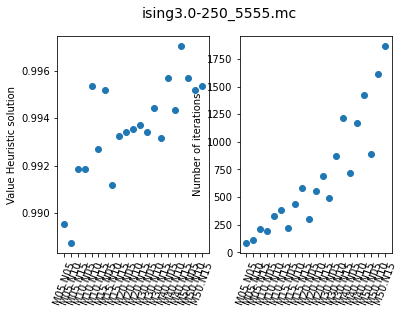

In [18]:
for instance in summary.nsmallest(10, 'max').index:
    plot_style(instance,r_bmk,itr)

In [19]:
bmk.loc['be100.1.mc']

index            40
instance    be100.1
#V              101
#E             5003
3               100
4              4903
5               100
opt          -19412
Name: be100.1.mc, dtype: object

# Analysis of instances without known optimum value

Scale the values by the maximum achieved value. The idea behind this is that we are interested in the change of the heuristic value not its absolute value. 

In [20]:
r_nk = val.loc[val.index.difference(bmk.index)]
for instance in r_nk.index:
    r_nk.loc[instance] = r_nk.loc[instance] / abs(r_nk.loc[instance].max(axis=0))

First we print a table containing the min value (ratio) the mean achieved value and the standard deviation.

In [21]:
nk_sum = r_nk.T.describe().T
nk_sum.head()
print(tabulate(nk_sum[['min','mean','std']], headers='keys', tablefmt='psql'))

+-----------------+----------+----------+-------------+
|                 |      min |     mean |         std |
|-----------------+----------+----------+-------------|
| G_1.mc          | 0.995266 | 0.998484 | 0.000940239 |
| G_10.mc         | 0.987342 | 0.993128 | 0.00323644  |
| G_11.mc         | 0.978571 | 0.991497 | 0.00535431  |
| G_12.mc         | 0.982014 | 0.989209 | 0.00440556  |
| G_13.mc         | 0.979381 | 0.988873 | 0.00484826  |
| G_14.mc         | 0.994439 | 0.997663 | 0.00161016  |
| G_15.mc         | 0.994085 | 0.998075 | 0.00150696  |
| G_16.mc         | 0.99376  | 0.997764 | 0.00137625  |
| G_17.mc         | 0.993423 | 0.997526 | 0.00161974  |
| G_18.mc         | 0.989868 | 0.995561 | 0.00267055  |
| G_19.mc         | 0.986726 | 0.993626 | 0.00370046  |
| G_2.mc          | 0.996466 | 0.998793 | 0.000887896 |
| G_20.mc         | 0.981915 | 0.995897 | 0.00432504  |
| G_21.mc         | 0.976268 | 0.991473 | 0.00635368  |
| G_22.mc         | 0.995193 | 0.998147 | 0.0011

As we can see there are instances with min 1. This means that each of the solvers attains the same heuristic solution. However this does not mean that the attained value is an optimum. This does not even imply that the global minimisation of the "Zielfunktion" f is the same point.
Nevertheless these instances are interesting in many ways:
- The maximum value could be plugged into the dual LP to see that gap (and thus test if it's optimal). But this can be done with any achieved optimum value.
    - If the heuristic value is not optimal, we can analyse the graph properties in hopes of finding something interesting

Compute a list of instances, for which the absolute value is not known but each of the solvers returns the same heuristic solution.

In [22]:
r_nk.loc[(r_nk==1).all(axis=1)].index

Index(['G_48.mc', 'G_49.mc', 'sg3dl051000.mc', 'sg3dl0510000.mc',
       'sg3dl053000.mc', 'sg3dl054000.mc', 'sg3dl055000.mc', 'sg3dl056000.mc',
       'sg3dl058000.mc', 'sg3dl059000.mc'],
      dtype='object')

Let us consider 10 instances, where min is lowest. This means that these are the 10 instances for which the difference between the highest heuristic solution and lowest heuristic solution is biggest.

In [23]:
nk_sum['min'].idxmin()

'sg3dl104000.mc'

In [24]:
#nk_sum.sort_values(by=['mean'])
#nk_sum.sort_values(ascending=False, by=['std'])

The next plot shows the instances ordered by their min (ascending), mean (ascending) and standard deviation (descending) side by side

In [25]:
mean_std = pd.DataFrame({ "min ascending" : nk_sum.sort_values(by=['min']).index, "mean ascending" : nk_sum.sort_values(by=['mean']).index, "std descending" : nk_sum.sort_values(ascending=False, by=['std']).index})
print(tabulate(mean_std,headers='keys', tablefmt='psql'))
#print( tabulate(nk_sum.sort_values(by=['mean']).index, nk_sum.sort_values(ascending=False, by=['std'])))

+----+-----------------+------------------+------------------+
|    | min ascending   | mean ascending   | std descending   |
|----+-----------------+------------------+------------------|
|  0 | sg3dl104000.mc  | G_41.mc          | sg3dl057000.mc   |
|  1 | G_41.mc         | G_13.mc          | G_21.mc          |
|  2 | G_21.mc         | sg3dl106000.mc   | G_41.mc          |
|  3 | sg3dl106000.mc  | G_12.mc          | G_28.mc          |
|  4 | sg3dl142000.mc  | sg3dl1010000.mc  | sg3dl106000.mc   |
|  5 | G_11.mc         | sg3dl143000.mc   | sg3dl104000.mc   |
|  6 | G_13.mc         | sg3dl108000.mc   | G_11.mc          |
|  7 | sg3dl101000.mc  | sg3dl109000.mc   | sg3dl105000.mc   |
|  8 | sg3dl1010000.mc | sg3dl104000.mc   | sg3dl1010000.mc  |
|  9 | sg3dl109000.mc  | sg3dl142000.mc   | sg3dl142000.mc   |
| 10 | G_28.mc         | G_9.mc           | sg3dl101000.mc   |
| 11 | G_9.mc          | G_21.mc          | G_13.mc          |
| 12 | sg3dl143000.mc  | G_11.mc          | sg3dl109000

Comparing the two tables above 